# Amazon case study 

# Final report in one section 
**Time taken**: 10 hours

**Task**: create an algorithm to identify whether a twitter user is a male/female/companybrand

## Brief EDA and preprocessing for modeling
**Goal:** Investigate the target, `gender`, ensure all labels are valid, and deal with any other issues with the target, such as duplicate samples. 

**Note**: We are only concerned here with modeling the target, `gender`, but the rows we drop may be useful for other analysis.

**`created` column**: After viewing the data, we are assuming this column is the date-time that the account was created, not when the tweet was tweeted, since there are rows where `name` and `created` are duplicated, but the `tweet_text` is different, which indicates that these rows represent different tweets. Since `created` is the same, it must be referring to the account creation date-time.

**Preprocessing summary**:
First we drop rows where `gender` is either "unknown" or NaN. Then we drop duplicate rows where `created`, `gender`, `name` and `tweet_text` are the same, keeping one row of the duplicates. Then we drop all rows where they are duplicated with respect to `created` and `name`, but have a different `gender` label. All these rows are dropped since we can't be sure how these should be labeled. Perhaps we will find a reason to include them in the future, but for now we will ignore them for modeling. 


## Cross validation and metric


**Chosen cross-validation scheme**: A simple group 5-fold split. The training set will have 80% of the data, and the test will have 20%.

**Chosen metric**: Accuracy - Since this is a ternary-classification problem with balanced labels, accuracy should be a reasonable metric. If we decide that we care more about one class than another, or if we want to first predict if a user is a brand or a person first, then predict gender, we could adjust our metric and modeling methods.

**Considerations**: 

 - **Time consideration**: Since there is no date-time for the tweet, we will make no consideration for time, but in general we can only build models on data from the past, so this should be included in future cross-validation schemes. 

 - **`names` with multiple tweets**: To be prudent, we should keep all tweets from a single user in the same fold.

 - **Target balance**: Since the target is well-balanced we don't need to ensure that all folds have the same ratio of labels. Also, the even balance means accuracy is a fine metric.
 

## Models - Are models final predictors are LGBMClassifiers
### baseline 1: 
This just uses numerical features and categorical features with cardinality less than 500
 - CV accuracy:  0.5430767105395358
 - Test set accuracy:  0.5396506287309207

### baseline 2: 
Starts with same features as before, but adds a lot of features derived from the high cardinality categorical variables such as tweet_text, name, profile_image, and user_description. 
 - CV accuracy:  0.5680787884877103
 - Test set accuracy:  0.566625326055983

### baseline 3: 
Same as 2, but used the name_gender.csv file. We find name that has the lowest Levenshtein distance, then add the probability that a person with that name is a female.

 - CV accuracy:  0.5933509996985833
 - Test set accuracy:  0.5947351585161803

** After tuning hyperparameters **
 - CV accuracy:  0.5958508626910113
 - Test set accuracy:  0.5958703228776221
 
## Next steps if time permits
 - We could do more with Levenshtein distance, maybe averaging the female_probability over the top k closest names. We could also strip out non-numerical characters before calculating the distance.
 - profile_pictures: With links to pictures, we could use an image classifier to identify male and female pictures.
 - Colors: For `link_color` and `sidebar_color` we could group the colors into better categories like red, orange, yellow etc. This would make these columns make more sense to algorithms. 
 - Analyze the tweets to discover high valued brands, along with talking to stakeholders to find out exactly what makes a brand high valued in their eyes.
 - Find out what a "high quality twitter user" is and identify them and the brands they interact with.

# Prompt
## Submission Notes:
Please use this take-home exercise as an opportunity to showcase your thinking process, various aspects of your hands-on skills, as well as your experience with different machine learning techniques.
Code: Please use whatever format that you deem appropriate.
Presentation: Please use whatever format you feel comfortable with, however, please treat the presentation document as an item that can be sent to a colleague via email without an opportunity for verbal communication. This emphasizes the need for clear written documentation.
You should also include how you plan to improve your work, if given more time or resources. The audience of the presentation document are data scientists / machine learning engineers.
We will assess your written submission and use that to decide if you will proceed to the next interview stage.
Citations: Please cite any code or algos that you refer to from the web.


### Data: 
Please treat the dataset provided as a raw form extracted from a data crawling service. There are 2 datasets attached to the email. "twitter_data.csv" contains the main twitter dataset for your training and prediction. "name_gender.csv" is a supplementary dataset that you have the option to use if relevant. Both datasets are encoded in "utf-8" format.
Good luck!

### Your Task
Our imaginary business is crawling the twitter feed and aims to create a network graph of company brands on twitter and understand the relationship between brands and users from the twitter links and mentions. Building up this graph would enable our business development team to identify and rank high value brands as sales leads that they could personally contact and try to sell our company's services to.
Further, the business would like to understand the customer demographics of different brands, and it has decided that user gender is one of the first demographic attributes to look into.
Some brands have their target customer base as males, while other brands are targeting females. Our company's marketing team has a very limited digital marketing budget, and plans to use the budget to programmatically acquire a limited set of high quality twitter users based on the user's gender.


To help the business, your task as a data scientist is to create an algorithm to identify whether a twitter user is a male/female/companybrand, and also explain any insights you have gained.
Our web crawler service has extracted the following dataset "twitter_data.csv" for your modelling and prediction use. Another data scientist from the team has shared with you a supplementary dataset "name_gender.csv" and you have the option to use it(or not) for your model training if you deem appropriate.

### My own notes: 
 * Our business wants to rank high value brands as sales leads. We also want understand the demographics of different brands. 
 * **Question**: what is a "high quality twitter user" and how could high quality be based solely on the persons gender?
 
  **Goals**
     - Goal 1: create an algorithm to identify whether a twitter user is a male/female/companybrand using the given data
     - Goal 2: explain any insights gathered while creating this model 
     - Goal 3: If time permits, look into building a graph of brands and customers
 

In [ ]:
import os
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# Modeling `gender`

## Brief EDA and preprocessing for modeling
**Goal:** Investigate the target, `gender`, ensure all labels are valid, and deal with any other issues with the target, such as duplicate samples. 

**Note**: We are only concerned here with modeling the target, `gender`, but the rows we drop may be useful for other analysis.

**`created` column**: After viewing the data, we are assuming this column is the date-time that the account was created, not when the tweet was tweeted, since there are rows where `name` and `created` are duplicated, but the `tweet_text` is different, which indicates that these rows represent different tweets. Since `created` is the same, it must be referring to the account creation date-time.

**Preprocessing summary**:
First we drop rows where `gender` is either "unknown" or NaN. Then we drop duplicate rows where `created`, `gender`, `name` and `tweet_text` are the same, keeping one row of the duplicates. Then we drop all rows where they are duplicated with respect to `created` and `name`, but have a different `gender` label. All these rows are dropped since we can't be sure how these should be labeled. Perhaps we will find a reason to include them in the future, but for now we will ignore them for modeling. 

In [ ]:
data = Path('data')
os.listdir(data)

['case study data.zip', 'name_gender.csv', 'twitter_data.csv', '__MACOSX']

name_gender.csv


,name,gender,probability
0,Aaban,M,1.0
1,Aabha,F,1.0
2,Aabid,M,1.0
3,Aabriella,F,1.0
4,Aada,F,1.0


gender values: ['M' 'F']
missing values


name           0
gender         0
probability    1
dtype: int64

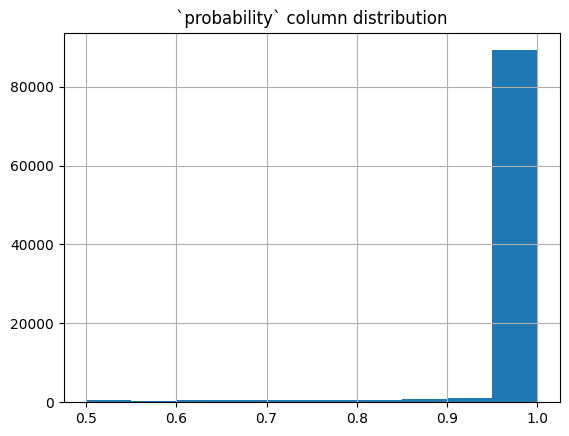

In [ ]:
print('name_gender.csv')
ng = pd.read_csv(data/'name_gender.csv')
display(ng.head())
print(f'gender values: {ng.gender.unique()}')
print('missing values')
display(ng.isna().sum())
ng.probability.hist()
plt.title('`probability` column distribution');

### twitter_data.csv

In [ ]:
td = pd.read_csv(data/'twitter_data.csv')
display(td.info())
display(td.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20048 entries, 0 to 20047
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   unit_id                20048 non-null  int64 
 1   gender                 19949 non-null  object
 2   created                20048 non-null  object
 3   user_description       16304 non-null  object
 4   user_favourite_number  20048 non-null  int64 
 5   link_color             20048 non-null  object
 6   name                   20048 non-null  object
 7   profileimage           20048 non-null  object
 8   retweet_count          20048 non-null  int64 
 9   sidebar_color          20048 non-null  object
 10  tweet_text             20048 non-null  object
 11  tweet_coord            159 non-null    object
 12  tweet_count            20048 non-null  int64 
 13  tweet_location         12564 non-null  object
 14  user_timezone          12250 non-null  object
dtypes: int64(4), object

None

,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone
0,815719226,male,12/05/2013 01:48,i sing my own rhythm.,0,08C2C2,sheezy0,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,main; @Kan1shk3,Chennai
1,815719227,male,10/01/2012 13:51,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...,NaN,7471,NaN,Eastern Time (US & Canada)
2,815719228,male,11/28/14 11:30,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,clcncl,Belgrade
3,815719229,male,06/11/2009 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,WilfordGemma,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,NaN,NaN


### Setting created as date column

In [ ]:
td['date'] = pd.to_datetime(td.created)
print('It looks like the date column was created successfully ')
display(td[['date', 'created']])

It looks like the date column was created successfully 


,date,created
0,2013-12-05 01:48:00,12/05/2013 01:48
1,2012-10-01 13:51:00,10/01/2012 13:51
2,2014-11-28 11:30:00,11/28/14 11:30
3,2009-06-11 22:39:00,06/11/2009 22:39
4,2014-04-16 13:23:00,4/16/14 13:23
...,...,...
20043,2012-02-21 18:36:00,2/21/12 18:36
20044,2013-08-16 14:48:00,8/16/13 14:48
20045,2011-08-11 10:01:00,08/11/2011 10:01
20046,2014-06-08 19:07:00,06/08/2014 19:07


### Missing data in tweet_data.csv
 * Our target "gender" is only missing half a percent
 * User description is missing around 18%
 * tweet_location and user_timezone are missing about 37 percent. 
 * tweet_coord is missing 99 percent and can probably be dropped 
 * all other columns are missing no data

In [ ]:
print('How much of the data is missing in each column')
(td.isna().mean().round(4) * 100).rename('percent_missing').to_frame()

How much of the data is missing in each column


,percent_missing
unit_id,0.00
gender,0.49
created,0.00
user_description,18.68
user_favourite_number,0.00
link_color,0.00
name,0.00
profileimage,0.00
retweet_count,0.00
sidebar_color,0.00


### Target distribution
We have about 5% labeled "unknown", and the remaining rows divided fairly evenly across female, male, and brand

In [ ]:
td.gender.value_counts(dropna=False)

female     6698
male       6192
brand      5942
unknown    1117
NaN          99
Name: gender, dtype: int64

In [ ]:
print('asserting that unit_id is a unique identifier for this data')
assert td.unit_id.duplicated().sum() == 0

asserting that unit_id is a unique identifier for this data


### Duplicated rows
Aftter investigation, we find that there are many rows that have the same values for `created` and `name`. These rows often have many other columns matching, but the columns don't match consistently enough to drop catch all duplicated accounts. I will assume that accounts that match in `created` and `name` are the same, but with some variables differing. If duplicated rows have different `gender` values, then I will discard them for building a classification model, since I'm not sure which class they belong to. These rows may be valuable for other analysis purposes. 

In [ ]:
print('For building a model, we will discard all rows with `gender` in (NaN, unknown)')
old = td.shape[0]
td.dropna(subset=['gender'], inplace=True)
print(f'We have dropped {old - td.shape[0]} rows where `gender` was NaN')

For building a model, we will discard all rows with `gender` in (NaN, unknown)
We have dropped 99 rows where `gender` was NaN


In [ ]:
old = td.shape[0]
td = td[td.gender != 'unknown']
print(f'We have dropped {old - td.shape[0]} rows where `gender` was "unknown"')

We have dropped 1117 rows where `gender` was "unknown"


Looking at instances where `name` and `created` are repeated, I see there are instances where `tweet_text` are the same and other instances where `tweet_text` are different. We will drop those where `tweet_text` is the same, but keep those where `tweet_text` is different because those rows are different in a meaningful way. To be prudent, we will keep all rows with the same user within the same cross-validation fold for modeling.

In [ ]:
dup_names = td.groupby('name').name.count()[td.groupby('name').name.count() > 1].index
td[td.name.isin(dup_names)].sort_values('name').head(20)

,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
6125,815725431,brand,2/17/14 10:46,Weather for 01302,0,0084B4,01302gnla,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,39989,NaN,NaN,2014-02-17 10:46:00
6029,815725335,brand,2/17/14 10:46,Weather for 01302,0,0084B4,01302gnla,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,39989,NaN,NaN,2014-02-17 10:46:00
9504,815728850,female,9/27/10 9:04,"Reporter for @global_nb, covering #NB legislat...",586,2FC2EF,01LBrown,https://pbs.twimg.com/profile_images/642528364...,0,181A1E,Change of pace today. Had the opportunity to s...,NaN,9565,"Fredericton, NB",Eastern Time (US & Canada),2010-09-27 09:04:00
1966,815721253,female,9/27/10 9:04,"Reporter for @global_nb, covering #NB legislat...",586,2FC2EF,01LBrown,https://pbs.twimg.com/profile_images/642528364...,0,181A1E,Thanks to the @atlanticJawards for lunch! #nb ...,NaN,9565,"Fredericton, NB",Eastern Time (US & Canada),2010-09-27 09:04:00
20021,815753796,brand,05/05/2014 12:48,NaN,0,0084B4,04630lktc,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,63448,NaN,NaN,2014-05-05 12:48:00
8051,815727369,brand,05/05/2014 12:48,NaN,0,0084B4,04630lktc,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,63448,NaN,NaN,2014-05-05 12:48:00
6099,815725405,brand,08/01/2014 13:20,NaN,0,0084B4,08026gnla,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,63240,NaN,NaN,2014-08-01 13:20:00
20007,815750417,brand,08/01/2014 13:20,NaN,0,0084B4,08026gnla,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,63240,NaN,NaN,2014-08-01 13:20:00
14543,815734005,female,04/08/2015 07:29,@JeRoss11 is my cutie,12138,992266,0beyjess,https://pbs.twimg.com/profile_images/658614858...,0,0,"@highkeyh no he loves Caroline now, that's aft...",NaN,30537,no bullshit zone,Eastern Time (US & Canada),2015-04-08 07:29:00
10172,815729528,female,04/08/2015 07:29,@JeRoss11 is my cutie,12138,992266,0beyjess,https://pbs.twimg.com/profile_images/658614858...,0,0,@highkeyh him and all that happened and then t...,NaN,30537,no bullshit zone,Eastern Time (US & Canada),2015-04-08 07:29:00


In [ ]:
print('Dropping rows duplicated in [name, created, gender, tweet_text], since we only want one instance of each account')
old = td.shape[0]
td.drop_duplicates(['name', 'gender', 'created', 'tweet_text'], inplace=True)
print(f'We have dropped {old - td.shape[0]} rows where [name, created, gender, tweet_text] were duplicated')

Dropping rows duplicated in [name, created, gender, tweet_text], since we only want one instance of each account
We have dropped 48 rows where [name, created, gender, tweet_text] were duplicated


In [ ]:
old = td.shape[0]
x = td.groupby(['name', 'created']).gender.nunique()
mask = td.set_index(['name', 'created']).index.isin(set(x[x > 1].index))
td = td[~mask]
print(f'We have dropped {old - td.shape[0]} rows where an account has multile `gender`s')

We have dropped 285 rows where an account has multile `gender`s


In [ ]:
print('asserting that `name` has only one unique `gender`, even if they have multiple tweets')
assert td.groupby('name').gender.nunique().max() == 1
print("asserting that all lables are in ['brand', 'female', 'male']")
set(td.gender.unique()) == set(['brand', 'female', 'male'])

asserting that `name` has only one unique `gender`, even if they have multiple tweets
asserting that all lables are in ['brand', 'female', 'male']


True

### Preprocessing function

In [ ]:
def preprocess_twitter_data(td): 
    start_rows = td.shape[0]
    print('For building a model, we will discard all rows with `gender` in (NaN, unknown)')
    old = td.shape[0]
    td.dropna(subset=['gender'], inplace=True)
    print(f'We have dropped {old - td.shape[0]} rows where `gender` was NaN')

    old = td.shape[0]
    td = td[td.gender != 'unknown']
    print(f'We have dropped {old - td.shape[0]} rows where `gender` was "unknown"')

    print('Dropping rows duplicated in [name, created, gender, tweet_text], since we \n\
    only want one instance of each account/tweet combination')
    old = td.shape[0]
    td = td.copy() # For some reason this prevents a warning message
    td.drop_duplicates(['name', 'gender', 'created', 'tweet_text'], inplace=True)
    print(f'We have dropped {old - td.shape[0]} rows where [name, created, gender, tweet_text] were duplicated')

    old = td.shape[0]
    x = td.groupby(['name', 'created']).gender.nunique()
    mask = td.set_index(['name', 'created']).index.isin(set(x[x > 1].index))
    td = td[~mask]
    print(f'We have dropped {old - td.shape[0]} rows where an account has multiple `gender`s')
    
    print('Creating `date_account_created` column from `created` and dropping `created`')
    td['date_account_created'] = pd.to_datetime(td.created)
    td = td.drop('created', axis='columns')
    print('rese')
    
    print('\n', f'We have dropped {start_rows - td.shape[0]} of {start_rows} rows')
    print('asserting that `name` has only one unique `gender, though they may have multiple tweets')
    assert td.groupby('name').gender.nunique().max() == 1
    print("asserting that all lables are in ['brand', 'female', 'male']")
    assert set(td.gender.unique()) == set(['brand', 'female', 'male'])
    dup_mask = td.name.duplicated(keep=False)
    print(f'There are {dup_mask.sum()} rows from accounts with multiple tweets')
    print(f'There are {td[dup_mask].name.nunique()} accounts with at least 2 tweets in the data')  
    return td

In [ ]:
td = preprocess_twitter_data(pd.read_csv(data/'twitter_data.csv'))

For building a model, we will discard all rows with `gender` in (NaN, unknown)
We have dropped 99 rows where `gender` was NaN
We have dropped 1117 rows where `gender` was "unknown"
Dropping rows duplicated in [name, created, gender, tweet_text], since we 
    only want one instance of each account/tweet combination
We have dropped 48 rows where [name, created, gender, tweet_text] were duplicated
We have dropped 285 rows where an account has multiple `gender`s
Creating `date_account_created` column from `created` and dropping `created`

 We have dropped 1549 of 20048 rows
asserting that `name` has only one unique `gender`, even if they have multiple tweets
asserting that all lables are in ['brand', 'female', 'male']
There are 1475 rows from accounts with multiple tweets
There are 587 accounts with at least 2 tweets in the data


## Cross validation and metric


**Chosen cross-validation scheme**: A simple group 5-fold train-test. The training set will have 80% of the data, and the test will have 20%. For each of the 5 iterations, we will develop a model on the train set and predict the test set only one time. 

**Chosen metric**: Accuracy - Since this is a ternary-classification problem with balanced labels, accuracy should be a reasonable metric. If we decide that we can more about one class than another, or if we want to first predict if a user is a brand or a person first, then predict gender, we could adjust our metric and modeling methods.

**Considerations**: 

 - **Time consideration**: Since there is no date-time for the tweet, we will make no consideration for time, but in general we can only build models on data from the past, so this should be included in future cross-validation schemes. 

 - **`names` with multiple tweets**: To be prudent, we should keep all tweets from a single user in the same fold.

 - **Target balance**: Since the target is well-balanced we don't need to ensure that all folds have the same ratio of labels. Also, the even balance means accuracy is a fine metric.


In [ ]:
def accuracy(y_true, y_pred): 
    """Returns the ratio correctly classified labels, with 1 being perfect"""
    return (y_true == y_pred).mean()

assert accuracy(np.array(['male', 'female', 'female', 'brand']), np.array(['male', 'female', 'male', 'brand'])) == .75

In [ ]:
from sklearn.model_selection import GroupKFold

def add_cv_folds(td): 
    """Returnd td with added `fold` column"""
    
    np.random.seed(0) # for reproducibility
    td = td.loc[np.random.permutation(td.index)] # to shuffle rows
    td = td.reset_index(drop=True)
    td['fold'] = 0
    kf = GroupKFold(n_splits=5)
    for fold, (trn_id, tst_id) in enumerate(kf.split(td, groups=td.name)): 
        print("Asserting there is no overlap in `name` between train and test sets")
        assert len(set(td.loc[trn_id].name).intersection(set(td.loc[tst_id].name))) == 0  
        td.loc[tst_id, 'fold'] = fold
    return td
td = preprocess_twitter_data(pd.read_csv(data/'twitter_data.csv'))
td = add_cv_folds(td)

For building a model, we will discard all rows with `gender` in (NaN, unknown)
We have dropped 99 rows where `gender` was NaN
We have dropped 1117 rows where `gender` was "unknown"
Dropping rows duplicated in [name, created, gender, tweet_text], since we 
    only want one instance of each account/tweet combination
We have dropped 48 rows where [name, created, gender, tweet_text] were duplicated
We have dropped 285 rows where an account has multiple `gender`s
Creating `date_account_created` column from `created` and dropping `created`

 We have dropped 1549 of 20048 rows
asserting that `name` has only one unique `gender`, even if they have multiple tweets
asserting that all lables are in ['brand', 'female', 'male']
There are 1475 rows from accounts with multiple tweets
There are 587 accounts with at least 2 tweets in the data
Asserting there is no overlap in `name` between train and test sets
Asserting there is no overlap in `name` between train and test sets
Asserting there is no over

## Baseline 1

### EDA for train set to find simple baseline 

In [ ]:
tst_fold = 0
test = td[td.fold == 0]
train = td[td.fold != 0]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14799 entries, 0 to 18498
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   unit_id                14799 non-null  int64         
 1   gender                 14799 non-null  object        
 2   user_description       12217 non-null  object        
 3   user_favourite_number  14799 non-null  int64         
 4   link_color             14799 non-null  object        
 5   name                   14799 non-null  object        
 6   profileimage           14799 non-null  object        
 7   retweet_count          14799 non-null  int64         
 8   sidebar_color          14799 non-null  object        
 9   tweet_text             14799 non-null  object        
 10  tweet_coord            128 non-null    object        
 11  tweet_count            14799 non-null  int64         
 12  tweet_location         9485 non-null   object        
 13  u

In [ ]:
train.describe()

In [ ]:
train.describe(include=['object']).T.sort_values('unique', ascending=False)

,count,unique,top,freq
name,14799,14090,Map_Game,24
tweet_text,14799,13734,EVERYDAYILOVEYOU Forevermore\r\n\r\nand what m...,133
profileimage,14799,13014,https://abs.twimg.com/sticky/default_profile_i...,174
user_description,12217,11509,"You can be spiritually empowered, financially ...",26
tweet_location,9485,6178,London,117
link_color,14799,2336,0084B4,7206
sidebar_color,14799,465,C0DEED,6586
user_timezone,9199,150,Eastern Time (US & Canada),1893
tweet_coord,128,118,"[27.8428, -82.6995]",2
gender,14799,3,female,5280


In [ ]:
train.describe(exclude=['object', 'datetime']).T#.sort_values('unique', ascending=False)

,count,mean,std,min,25%,50%,75%,max
unit_id,14799.0,8.157294e+08,5894.753860,815719226.0,815724300.5,815729407.0,815734459.5,815757985.0
user_favourite_number,14799.0,4.316522e+03,12424.076214,0.0,13.0,471.0,3334.5,341621.0
retweet_count,14799.0,8.081627e-02,2.807291,0.0,0.0,0.0,0.0,330.0
tweet_count,14799.0,3.974600e+04,127407.680970,1.0,2389.5,11335.0,39729.0,2680199.0
fold,14799.0,2.499899e+00,1.118042,1.0,1.5,2.0,3.0,4.0


### Pipeline

CV accuracy:  0.5430767105395358
Test set accuracy:  0.5396506287309207


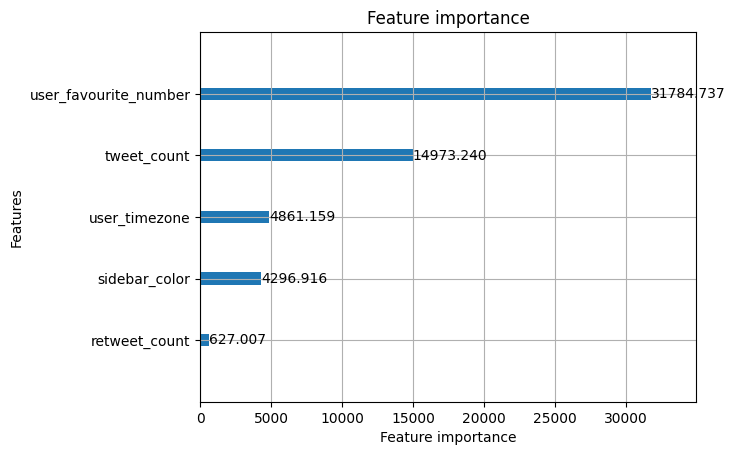

In [ ]:
cat_cols = ['tweet_coord', 'user_timezone', 'sidebar_color']
num_cols = ['user_favourite_number', 'retweet_count', 'tweet_count']
feature_cols = cat_cols + num_cols

def process(df): 
    df[cat_cols] = df[cat_cols].astype('category')
    return df[feature_cols]

p0 = make_pipeline(
    FunctionTransformer(process), 
    LGBMClassifier()
)
cv = cross_validate(p0, 
                    train, 
                    train['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=train['fold'])
print('CV accuracy: ', cv['test_score'].mean())

cv = cross_validate(p0, 
                    td, 
                    td['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=td['fold'])
print('Test set accuracy: ', cv['test_score'].mean())
p0.fit(td, td['gender'])
lgb.plot_importance(p0.named_steps.lgbmclassifier, importance_type='gain');

## Baseline 2

In [ ]:
'''We will try to find some heuristics to separate the data. 
For reference, here is the value counts ratio of `gender` for all training data.'''
display((train.gender.value_counts() / train.shape[0]).sort_index())

brand     0.314346
female    0.356781
male      0.328874
Name: gender, dtype: float64

After a brief look at some rows for each label, I cannot see any obvious trends to easily distinguish the labels

In [ ]:
f = train[train.gender == 'female']
m = train[train.gender == 'male']
b = train[train.gender == 'brand']
display(f)
display(m)
display(b)

,unit_id,gender,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date_account_created,fold
0,815724279,female,"A true red-headed, blue-eyed, left-handed, Pis...",4,666666,YIF_JAK,https://pbs.twimg.com/profile_images/109204509...,0,333333,Helping a friend make his 'The Skin That Stalk...,NaN,7430,PA,Eastern Time (US & Canada),2009-03-16 15:43:00,4
6,815733250,female,Have Courage & Be Kind ‰Ï¬,16414,0099B9,Alliekat516,https://pbs.twimg.com/profile_images/642915317...,0,5ED4DC,And this is why @ColtonLHaynes is forever my #...,NaN,22767,SEA ‰Ïö•ü WDW,Pacific Time (US & Canada),2012-04-11 22:44:00,3
7,815731505,female,ig: vivaciousvivv ‰Û¢ vilseck '17 ‰Û¢ living l...,1644,3B94D9,viridianaserena,https://pbs.twimg.com/profile_images/658371793...,0,FFFFFF,"@BobbyFort stalk Audree, she a baddie and she'...",NaN,2187,Hahnbach,Pacific Time (US & Canada),2013-04-05 05:07:00,1
12,815735365,female,"‰ÛÏBe kind, for everyone you meet is fighting ...",4335,DD2E44,aicev,https://pbs.twimg.com/profile_images/655014142...,0,FFFFFF,making bubble and matrix diagrams for seven di...,NaN,31633,MNL,Alaska,2009-04-23 21:03:00,2
13,815722071,female,"Striving toward an ethereal, intriguing, exqui...",834,0084B4,alina5222,https://pbs.twimg.com/profile_images/630281299...,0,C0DEED,But if the speed limit is 40.. Best believe I'...,NaN,371,NaN,NaN,2010-04-30 11:02:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18481,815725840,female,NaN,1779,BB2266,01paigee,https://pbs.twimg.com/profile_images/535956566...,0,A8C7F7,My bed makes me the happiest girl in the world.,NaN,312,NaN,NaN,2013-08-21 17:14:00,4
18484,815737847,female,Host of The Arlene Bynon Show heard LIVE weekd...,58,0084B4,ArleneBynonShow,https://pbs.twimg.com/profile_images/438424439...,0,FFFFFF,Talking about 24 Sussex and life after #Elxn42...,NaN,2666,"Toronto, Canada",Eastern Time (US & Canada),2010-10-28 10:14:00,2
18490,815736647,female,"Celebrity Makeup Artist, Film & TV, Special FX...",140,9266CC,MuaMeredith,https://pbs.twimg.com/profile_images/625049155...,0,FFFFFF,Alien invasion!! \r\nmehronmakeup black and wh...,NaN,565,ATL,Eastern Time (US & Canada),2008-08-12 18:55:00,2
18492,815735658,female,Extreme communicator. Proud music trailblazer....,1733,0084B4,OliviaPerez250,https://pbs.twimg.com/profile_images/588278361...,0,C0DEED,"in series 6, poultney and her partner, bbc rad...",NaN,7574,USA,Eastern Time (US & Canada),2015-04-15 02:47:00,4


,unit_id,gender,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date_account_created,fold
2,815724555,male,2010 Arrowhead Elementary spelling bee champion,8046,0084B4,calebthompson05,https://pbs.twimg.com/profile_images/640042859...,0,C0DEED,@Olivia_Mullen13 @OHSdarts I hope I make the f...,NaN,5901,Go Braves,NaN,2013-02-18 21:05:00,1
3,815723647,male,"Techie, Bilingual Spanish Ed & MPA Grad, Boise...",97,1F98C7,BroncoP3t3_,https://pbs.twimg.com/profile_images/579437531...,0,1AAEED,Thanks for the retweets this week @irishbronco...,NaN,22562,"Nampa, ID",NaN,2009-04-24 14:44:00,1
4,815733006,male,"Redeemed by grace through faith, #Detroit & #Y...",59,0084B4,IsmailZain,https://pbs.twimg.com/profile_images/561608094...,0,FFFFFF,@daniel_dudley Shocking and sad :( #MIS2015,NaN,7879,"Windsor, Ontario, Canada",Eastern Time (US & Canada),2009-04-07 09:58:00,4
8,815737245,male,"I'm a farmer, with dreams.",48,0084B4,TebogoRTM,https://pbs.twimg.com/profile_images/554887903...,0,C0DEED,@CassperNyovest I see The Game and Talib Kweli...,NaN,132,Pretoria,NaN,2014-12-07 09:25:00,2
9,815731524,male,19 not out ‰ÏÎ•ü,3743,0084B4,One_Lund96,https://pbs.twimg.com/profile_images/656072016...,0,C0DEED,"If North and Jon Davies come back next season,...",NaN,12154,"Wales, United Kingdom",London,2012-05-26 13:20:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,815736201,male,"Kidd, 509/WSU‰Ï•ü, And I got what it takes t...",933,0084B4,K_i_DoubleD,https://pbs.twimg.com/profile_images/631165640...,0,C0DEED,And Just like that Arian Foster is out for the...,NaN,57633,"Pullman, WA",Pacific Time (US & Canada),2011-04-03 18:10:00,4
18493,815734759,male,Basketball Lover,122,88253,ope_adroit,https://pbs.twimg.com/profile_images/655378573...,0,D3D2CF,See all those boys wey dey sell plantain chips...,NaN,108178,NaN,NaN,2009-09-01 05:13:00,1
18495,815733666,male,NaN,762,DD2E44,Dvrith,https://pbs.twimg.com/profile_images/658499912...,0,0,@Treyflyy smacked and positive vibes https://t...,NaN,2543,"Scottsdale, AZ",NaN,2015-08-23 13:33:00,3
18497,815731129,male,why would i need the sun when you are the brig...,5720,0084B4,CUMHEMMlNGS,https://pbs.twimg.com/profile_images/658361417...,0,C0DEED,@ems0125 3 hours and 12 minutes https://t.co/9...,NaN,23141,uk ‰Û¢ sunshine/4 ‰Û¢ soph is mine,Dublin,2015-02-09 04:47:00,3


,unit_id,gender,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date_account_created,fold
1,815725526,brand,NaN,0,0084B4,07029jcsb,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,39514,NaN,NaN,2014-07-01 10:09:00,4
5,815736261,brand,I‰Ûªm here 'cause I have to stick around 'til ...,720,DD2E44,ApplesForRyuk,https://pbs.twimg.com/profile_images/658694605...,0,0,"@DetectiveDolci --Ryuzaki, his ghoulish face j...",NaN,4662,~Always hovering behind you~,Arizona,2012-05-12 11:39:00,2
18,815725023,brand,20 Years | Radio DJ | Music | A Big Fan Of @Al...,2139,0084B4,ILoveMusic_USA,https://pbs.twimg.com/profile_images/598781130...,0,BDDCAD,Scientists have discovered that the comet Love...,NaN,14728,"Los Angeles, CA",Pacific Time (US & Canada),2011-11-14 08:16:00,4
20,815720052,brand,Publishing original work and authors' guilty p...,228,13570C,EchoPressBooks,https://pbs.twimg.com/profile_images/638013251...,0,0,You're invited to read #free chapters! THE PIR...,NaN,290998,code room,Atlantic Time (Canada),2013-07-27 09:40:00,1
32,815730249,brand,Loralei‰Ûªs On Main is a New Shopping Experien...,14,FF0000,LoraleisOnMain,https://pbs.twimg.com/profile_images/350892550...,0,65B0DA,Roma Boots &amp; Sadie Robertson paired up .. ...,NaN,9918,"Sevierville, TN",Eastern Time (US & Canada),2011-01-30 10:49:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18475,815721305,brand,Health It Caucus,0,ABB8C2,HealthItCaucus,https://pbs.twimg.com/profile_images/574983835...,0,0,Brief : The #significant #impact of the #OPM ...,NaN,16856,DC,Eastern Time (US & Canada),2011-03-26 04:40:00,1
18478,815724544,brand,NaN,0,0084B4,26560stwb,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,69650,NaN,NaN,2014-08-22 22:59:00,4
18480,815721625,brand,We keep you updated with all news about Simona...,146,FA743E,LosHalepenos,https://pbs.twimg.com/profile_images/658337878...,1,0,Pop culture quiz via WTA _Ù÷_ @Simona_Halep i...,NaN,209,worldwide,Pacific Time (US & Canada),2015-09-25 14:31:00,1
18486,815730609,brand,Official account for banggothebangles on tumbl...,48,3B94D9,banglesfanclub,https://pbs.twimg.com/profile_images/658716396...,0,FFFFFF,"Photoset: ‰ÛÏFrom the first chord, The Bangles...",NaN,659,"Scotland, United Kingdom",London,2012-06-12 12:07:00,3


#### `tweet_text`
I'll start by seeing if I can find some signal just from the words used in a tweet.

In [ ]:
def get_word_count(df, column='tweet_text'): 
    all_words = ' '.join(df[column].tolist()).split(' ')
    all_words = [x.lower() for x in all_words]
    return pd.Series(Counter(all_words)).sort_values(ascending=False)

def get_word_count_df(wc_list): 
    return pd.concat(wc_list, axis=1)

In [ ]:
def get_wcdf(train, column='tweet_text'): 
    fcnt = get_word_count(train[train.gender == 'female'], column)
    mcnt = get_word_count(train[train.gender == 'male'], column)
    bcnt = get_word_count(train[train.gender == 'brand'], column)
    wcdf = get_word_count_df([bcnt, fcnt, mcnt])
    wcdf.columns = ['brand', 'female', 'male']
    return wcdf

In [ ]:
wcdf_tweet_text = get_wcdf(train, column='tweet_text')

From looking at the word counts, 'weather', 'updates', and 'channel.' could tell us if the user is a brand or a person. 

In [ ]:
wcdf_tweet_text.head(20)

,brand,female,male
the,3765.0,3723.0,3905.0
and,2202.0,3674.0,3080.0
weather,1834.0,10.0,11.0
to,1127.0,1769.0,1587.0
from,1110.0,181.0,191.0
get,1057.0,267.0,265.0
of,939.0,1015.0,1109.0
updates,921.0,3.0,1.0
channel.,914.0,2.0,2.0
a,823.0,1220.0,1356.0


Further investigation shows that if the `tweet_text` has at least one of 'updates', 'weather', or 'channel.', it is almost certainly a "brand", but a row does not contain any of those words, we cannot tell anything.

In [ ]:
train = train.copy() # avoids warning message
for word in ['updates', 'weather', 'channel.']: 
    train[f'tweet_contains_{word}'] = train.tweet_text.str.lower().str.contains(word).astype(int)

for word in ['updates', 'weather', 'channel.']:
    print(f'`gender` value counts of rows with "{word}"')
    display(train[train[f'tweet_contains_{word}'] == 1].gender.value_counts())
    
    print(f'`gender` value counts of rows without "{word}"')
    display(train[train[f'tweet_contains_{word}'] == 0].gender.value_counts())

print(f"`gender` value counts of rows without any of ['updates', 'weather', 'channel.']")
display(train[(train[f'tweet_contains_updates'] == 0) \
              & (train[f'tweet_contains_weather'] == 0) \
              & (train[f'tweet_contains_channel.'] == 0)].gender.value_counts())

print(f"`gender` value counts of rows with at least one of ['updates', 'weather', 'channel.']")
display(train[(train[f'tweet_contains_updates'] == 1) \
              | (train[f'tweet_contains_weather'] == 1) \
              | (train[f'tweet_contains_channel.'] == 1)].gender.value_counts())

`gender` value counts of rows with "updates"


brand     922
female      7
male        4
Name: gender, dtype: int64

`gender` value counts of rows without "updates"


female    5273
male      4863
brand     3730
Name: gender, dtype: int64

`gender` value counts of rows with "weather"


brand     922
female     11
male       10
Name: gender, dtype: int64

`gender` value counts of rows without "weather"


female    5269
male      4857
brand     3730
Name: gender, dtype: int64

`gender` value counts of rows with "channel."


brand     921
male       10
female      6
Name: gender, dtype: int64

`gender` value counts of rows without "channel."


female    5274
male      4857
brand     3731
Name: gender, dtype: int64

`gender` value counts of rows without any of ['updates', 'weather', 'channel.']


female    5260
male      4845
brand     3715
Name: gender, dtype: int64

`gender` value counts of rows with at least one of ['updates', 'weather', 'channel.']


brand     937
male       22
female     20
Name: gender, dtype: int64

In [ ]:
g = train.tweet_text.str.contains('@')
print('conains @')
display(train.groupby(g).gender.apply(lambda x: x.value_counts() / len(x)).sort_index())

print('conains #')
g = train.tweet_text.str.contains('#')
train.groupby(g).gender.apply(lambda x: x.value_counts() / len(x)).sort_index()

conains @


tweet_text        
False       brand     0.365607
            female    0.354973
            male      0.279421
True        brand     0.211574
            female    0.360406
            male      0.428020
Name: gender, dtype: float64

conains #


tweet_text        
False       brand     0.285326
            female    0.371128
            male      0.343546
True        brand     0.427719
            female    0.300729
            male      0.271552
Name: gender, dtype: float64

#### `user_description`

From first look I don't see any great words to use

In [ ]:
_train = train.copy() # Since NaNs will mess up `get_wcdf`
_train['user_description'] = _train['user_description'].fillna('NAN')
wcdf_user_desc = get_wcdf(_train, column='user_description')
df = pd.concat([wcdf_user_desc, wcdf_user_desc.div(wcdf_user_desc.sum(axis=1), axis=0).add_suffix('_ratio')], axis=1)
df.head(20)

,brand,female,male,brand_ratio,female_ratio,male_ratio
the,1644.0,1023.0,1208.0,0.424258,0.264000,0.311742
and,1477.0,1213.0,1328.0,0.367596,0.301891,0.330513
nan,1251.0,773.0,558.0,0.484508,0.299380,0.216112
to,922.0,731.0,714.0,0.389523,0.308830,0.301648
for,915.0,386.0,529.0,0.500000,0.210929,0.289071
of,835.0,785.0,1051.0,0.312617,0.293897,0.393486
a,821.0,975.0,898.0,0.304751,0.361915,0.333333
,798.0,1605.0,1888.0,0.185971,0.374039,0.439991
in,639.0,511.0,545.0,0.376991,0.301475,0.321534
&,579.0,473.0,522.0,0.367853,0.300508,0.331639


In [ ]:
display(f.user_description[:50].tolist())
display(m.user_description[:50].tolist())
display(b.user_description[:50].tolist())

['A true red-headed, blue-eyed, left-handed, Piscean. Consider that your warning.',
 'Have Courage & Be Kind ‰Ï¬',
 "ig: vivaciousvivv ‰Û¢ vilseck '17 ‰Û¢ living life to the best of my ability through God ‰Û¢ Aquarius",
 '‰ÛÏBe kind, for everyone you meet is fighting a battle you know nothing about.‰Û\x9d ‰Û¥ Wendy Mass, The Candymakers',
 'Striving toward an ethereal, intriguing, exquisite, and beautiful mindset.',
 'I like reading books, eating pizza, and watching football. Sometimes I do all three at the same time.',
 'You are my life I love you I admire you I helped with your voice in the dark moments @Luke5sos',
 '25 years; spicecitey; fashion. drama. alcopops!',
 'Jack of all trades, master of puns.\r\n\r\nPublic Relations Manager at @USVetsInc. \r\n\r\nTweets my own.',
 'passionate about people. creator of the InterPlay Inspiration Deck #IID, artist, visionary, movement and breath missionary: seeking beauty everywhere!',
 'California Grown; ‰\x9d_•ü\x8f of the Bay Area; News Rep

['2010 Arrowhead Elementary spelling bee champion',
 'Techie, Bilingual Spanish Ed & MPA Grad, Boise State Alum, Family, Macs, Android, Music, Sci-Fi and Fun! &  Boise State! Go Broncos! *My opinions are my own*',
 'Redeemed by grace through faith, #Detroit & #YQG Fan, Health Innovation Broker,  Youth Entrepreneurship Coach. Liberty Minded, ENFJ',
 "I'm a farmer, with dreams.",
 '19 not out ‰ÏÎ•ü\x8f',
 'A humble porter at Holby City ED! Step-brother to nurse Robyn and engaged to a consultant',
 'Family, Friends and FUN',
 'ford RS owner and fan of all things ford RS,very keen golfer and big fan of most sport and motorsport',
 "i don't have a dick either",
 'Dancing drummer @sanferminband, shirtless vibraphonist @hess_is_more, angry guitarist @futurewifeband. New music: https://t.co/0C2pVYoclV',
 'meh.',
 '#FairVotesNOW',
 'I think, therefore I tweet.',
 'blogger ‰Û¢ fashionisto ‰Û¢ comedian ‰Û¢ lifestyle ‰Û¢ teacher ‰Û¢ onika ‰Û¢ instagram: bensebrex',
 'Nottingham Forest fan for 35 y

[nan,
 "I‰Ûªm here 'cause I have to stick around 'til the Death Note is finished or I see you die, whichever comes first. So... Whadya gonna do with it~? |Anime/Drama/MV|",
 '20 Years | Radio DJ | Music | A Big Fan Of @AlexisJordan @Beyonce @ToriKelly @SelenaGomez @CurlyFryzMusic @EdSheeran and @CharlieSheen | #TeamAJ #TeamToriKelly',
 "Publishing original work and authors' guilty pleasures...",
 'Loralei‰Ûªs On Main is a New Shopping Experience that is relaxing and unique. I try to ensure that you will find the perfect gift for any occasion.',
 'Love your home? Join us for #roomjunkiechat every Monday from 8pm to 9pm.Answering questions, tips, trends & inspiration. Hosted by Anne Tuohy @rooomjunkiecom',
 nan,
 "Are you a Singer or Songwriter? UPLOAD your music. We'll play it ON AIR the same day. We play Rock. http://t.co/IZI3ZuOvEA  https://t.co/Z8USp09yhk",
 nan,
 'Weather for 02128',
 nan,
 'Anytime Fitness Telford, the only 24 hour gym in the area offering top of the range Life Fit

In [ ]:
g = train.user_description.str.contains('@')
print('conains @')
display(train.groupby(g).gender.apply(lambda x: x.value_counts() / len(x)).sort_index())

print('conains #')
g = train.user_description.str.contains('#')
train.groupby(g).gender.apply(lambda x: x.value_counts() / len(x)).sort_index()

conains @


user_description        
False             brand     0.274386
                  female    0.379416
                  male      0.346198
True              brand     0.301499
                  female    0.308162
                  male      0.390339
Name: gender, dtype: float64

conains #


user_description        
False             brand     0.272542
                  female    0.381753
                  male      0.345705
True              brand     0.309610
                  female    0.300260
                  male      0.390130
Name: gender, dtype: float64

#### `user_favourite_number`
When this is 0 we most likely have a brand

In [ ]:
display(f.user_favourite_number[:50].tolist())
display(m.user_favourite_number[:50].tolist())
display(b.user_favourite_number[:50].tolist())

[4,
 16414,
 1644,
 4335,
 834,
 3329,
 6987,
 2820,
 3285,
 0,
 1851,
 0,
 1337,
 33893,
 3688,
 37,
 3354,
 2810,
 15,
 2563,
 235,
 8496,
 0,
 4151,
 1748,
 3886,
 83,
 356,
 638,
 34710,
 871,
 1010,
 3854,
 5893,
 824,
 228,
 23613,
 862,
 0,
 1080,
 849,
 4381,
 4169,
 39065,
 32886,
 142,
 17566,
 43,
 4965,
 3669]

[8046,
 97,
 59,
 48,
 3743,
 62,
 2213,
 727,
 6819,
 7845,
 1748,
 1021,
 1177,
 704,
 99,
 77345,
 593,
 1339,
 880,
 40836,
 154,
 532,
 66074,
 2080,
 16836,
 2892,
 92,
 10460,
 3309,
 5509,
 11045,
 111,
 67,
 3879,
 5017,
 8646,
 15941,
 4067,
 13739,
 4329,
 14,
 35039,
 3211,
 1021,
 0,
 1614,
 29325,
 10465,
 273,
 3291]

[0,
 720,
 2139,
 228,
 14,
 175,
 0,
 6,
 0,
 0,
 0,
 87,
 43,
 854,
 0,
 0,
 0,
 0,
 60,
 490,
 5875,
 0,
 0,
 33,
 0,
 0,
 172,
 8034,
 0,
 1841,
 5,
 0,
 5,
 0,
 882,
 0,
 16,
 265,
 95,
 3825,
 5367,
 1,
 0,
 0,
 4,
 576,
 3342,
 0,
 5897,
 0]

In [ ]:
train.groupby(train.user_favourite_number == 0).gender.apply(lambda x: x.value_counts() / len(x)).sort_index()

user_favourite_number        
False                  brand     0.230417
                       female    0.397927
                       male      0.371656
True                   brand     0.758503
                       female    0.139031
                       male      0.102466
Name: gender, dtype: float64

In [ ]:
display(f[['sidebar_color', 'link_color']].iloc[:50])
display(m[['sidebar_color', 'link_color']].iloc[:50])
display(b[['sidebar_color', 'link_color']].iloc[:50])

,sidebar_color,link_color
0,333333,666666
6,5ED4DC,0099B9
7,FFFFFF,3B94D9
12,FFFFFF,DD2E44
13,C0DEED,0084B4
15,FFFFFF,FF974B
16,0,B0B0B0
21,DA65B7,DE9797
23,FFFFFF,0084B4
25,BF0606,8C0707


,sidebar_color,link_color
2,C0DEED,0084B4
3,1AAEED,1F98C7
4,FFFFFF,0084B4
8,C0DEED,0084B4
9,C0DEED,0084B4
10,C0DEED,0084B4
11,FFFFFF,0084B4
14,C0DEED,0084B4
22,0,FFA8AB
24,FFFFFF,284F49


,sidebar_color,link_color
1,C0DEED,0084B4
5,0,DD2E44
18,BDDCAD,0084B4
20,0,13570C
32,65B0DA,FF0000
33,C0DEED,0084B4
34,C0DEED,0084B4
36,0,104114
39,C0DEED,0084B4
41,C0DEED,0084B4


In [ ]:
wcdf_tweet_text = get_wcdf(train, column='tweet_text')

Does a columns missing a value tell us anything about the distribution of `gender`? There definitely seems to be some signal with these columns.

In [ ]:
train.isna().sum()[train.isna().sum() > 0].index

Index(['user_description', 'tweet_coord', 'tweet_location', 'user_timezone'], dtype='object')

In [ ]:
for col in train.isna().sum()[train.isna().sum() > 0].index: 
    print(f'`gender` value counts ratios of rows with missing "{col}"')
    df = train[train[col].isna()]
    display((df.gender.value_counts() / df.shape[0]).sort_index())
    
    print(f'`gender` value counts ratios of rows WITHOUT missing "{col}"')
    df = train[~train[col].isna()]
    display((df.gender.value_counts() / df.shape[0]).sort_index())

`gender` value counts ratios of rows with missing "user_description"


brand     0.484508
female    0.299380
male      0.216112
Name: gender, dtype: float64

`gender` value counts ratios of rows WITHOUT missing "user_description"


brand     0.278383
female    0.368912
male      0.352705
Name: gender, dtype: float64

`gender` value counts ratios of rows with missing "tweet_coord"


brand     0.312794
female    0.357644
male      0.329562
Name: gender, dtype: float64

`gender` value counts ratios of rows WITHOUT missing "tweet_coord"


brand     0.492188
female    0.257812
male      0.250000
Name: gender, dtype: float64

`gender` value counts ratios of rows with missing "tweet_location"


brand     0.397441
female    0.354159
male      0.248400
Name: gender, dtype: float64

`gender` value counts ratios of rows WITHOUT missing "tweet_location"


brand     0.267791
female    0.358250
male      0.373959
Name: gender, dtype: float64

`gender` value counts ratios of rows with missing "user_timezone"


brand     0.386607
female    0.330893
male      0.282500
Name: gender, dtype: float64

`gender` value counts ratios of rows WITHOUT missing "user_timezone"


brand     0.270355
female    0.372540
male      0.357104
Name: gender, dtype: float64

#### `profileimage`
From a quick glance at the first 50 rows, it seams that brands have "sticky" as part of the string.

In [ ]:
display(f.profileimage[:50].tolist())
display(m.profileimage[:50].tolist())
display(b.profileimage[:50].tolist())

['https://pbs.twimg.com/profile_images/1092045092/YIF_JAK_normal.JPG',
 'https://pbs.twimg.com/profile_images/642915317962817536/ORjQW2-x_normal.jpg',
 'https://pbs.twimg.com/profile_images/658371793267376128/P3e_dxW0_normal.jpg',
 'https://pbs.twimg.com/profile_images/655014142785404928/rW4WP1o__normal.jpg',
 'https://pbs.twimg.com/profile_images/630281299605884928/gEZzb-p__normal.jpg',
 'https://pbs.twimg.com/profile_images/605144102166884352/0AXt6dEx_normal.jpg',
 'https://pbs.twimg.com/profile_images/639054251113771008/_foGFUM8_normal.jpg',
 'https://pbs.twimg.com/profile_images/656633578315489284/ADi5GLU2_normal.jpg',
 'https://pbs.twimg.com/profile_images/635938805833338880/_4MH6Dk0_normal.jpg',
 'https://pbs.twimg.com/profile_images/378800000410423769/29ad7a977c68a75f32039355f58a41b2_normal.jpeg',
 'https://pbs.twimg.com/profile_images/619707000180469760/h8MB1lYK_normal.jpg',
 'https://pbs.twimg.com/profile_images/1257361059/gyuhwa_normal.png',
 'https://pbs.twimg.com/profile_im

['https://pbs.twimg.com/profile_images/640042859794726912/l8IGQHWy_normal.jpg',
 'https://pbs.twimg.com/profile_images/579437531063676928/oDOldHJq_normal.jpg',
 'https://pbs.twimg.com/profile_images/561608094132629504/RU6uFsVc_normal.jpeg',
 'https://pbs.twimg.com/profile_images/554887903877529600/G__NIuUA_normal.jpeg',
 'https://pbs.twimg.com/profile_images/656072016961912832/AEsdepEz_normal.jpg',
 'https://pbs.twimg.com/profile_images/627596918777114625/qxLbwekI_normal.jpg',
 'https://pbs.twimg.com/profile_images/554381668862025728/vIFs-sQf_normal.jpeg',
 'https://pbs.twimg.com/profile_images/1803197673/mms_img-1591716964_normal.jpg',
 'https://pbs.twimg.com/profile_images/656875811866173440/NR8R4NrU_normal.jpg',
 'https://pbs.twimg.com/profile_images/3473130499/710ec5f69dd7acc4a86d100bbb0a1b28_normal.jpeg',
 'https://pbs.twimg.com/profile_images/637887041246662656/-IW2ey1O_normal.jpg',
 'https://pbs.twimg.com/profile_images/1993126788/20120216_165503_normal.jpg',
 'https://pbs.twimg

['https://abs.twimg.com/sticky/default_profile_images/default_profile_1_normal.png',
 'https://pbs.twimg.com/profile_images/658694605626454016/YTn4REAQ_normal.jpg',
 'https://pbs.twimg.com/profile_images/598781130427342848/BeCPIVdy_normal.jpg',
 'https://pbs.twimg.com/profile_images/638013251154919424/tGiNGOzg_normal.jpg',
 'https://pbs.twimg.com/profile_images/3508925500/6c57f4267cc464007d7175f633f12c0f_normal.jpeg',
 'https://pbs.twimg.com/profile_images/630327582496456704/N9Zq4v4__normal.png',
 'https://abs.twimg.com/sticky/default_profile_images/default_profile_0_normal.png',
 'https://pbs.twimg.com/profile_images/2488306185/r2y8xs7lkx75whrl8gvm_normal.jpeg',
 'https://pbs.twimg.com/profile_images/647663761587744769/4JUiHM4n_normal.jpg',
 'https://abs.twimg.com/sticky/default_profile_images/default_profile_3_normal.png',
 'https://abs.twimg.com/sticky/default_profile_images/default_profile_3_normal.png',
 'https://pbs.twimg.com/profile_images/422482980779466752/qNNwBwfN_normal.png'

In [ ]:
mask = train.profileimage.str.contains('sticky')
display(train[mask].gender.value_counts())
display(train[~mask].gender.value_counts())

brand     1013
male        53
female      28
Name: gender, dtype: int64

female    5252
male      4814
brand     3639
Name: gender, dtype: int64

But it looks like there is a large overlap with the "sticky" rows and the rows with the other key words we found.

In [ ]:
display(train[(train[f'tweet_contains_updates'] == 1) \
              | (train[f'tweet_contains_weather'] == 1) \
              | (train[f'tweet_contains_channel.'] == 1)
              | mask].gender.value_counts())

brand     1036
male        74
female      46
Name: gender, dtype: int64

#### `name`
Looking at the first 50 names of each class, I question if some of the "brands" are really brands. But doubts aside, there seems to be more brands that start with digits. 

In [ ]:
display(f.name[:50].tolist())
display(m.name[:50].tolist())
display(b.name[:50].tolist())

['YIF_JAK',
 'Alliekat516',
 'viridianaserena',
 'aicev',
 'alina5222',
 'bookmarklit',
 'lukeshyness',
 'JosefinePraline',
 'fullofshark',
 'anitabondi',
 'tliou',
 'utau_gyuhwa',
 'caitlynfarrell4',
 'RainbowDemi314',
 'TommoTillTheEnd',
 'ApartmentsiLike',
 'fergusonjanette',
 'Mackenna_Daly',
 'KRBwrites',
 'ChloRochellex',
 'phoebemakeup',
 'sara_9496',
 'hanlon_keith',
 'DanielHerfeldt',
 'ohmymichelle_',
 'LovelyThaliaa',
 'Jizzy_Ive',
 'CaroleBeavis',
 'mary_christina_',
 'sianfreyaxo',
 'Sinful_Novakk',
 'amyhanauer',
 'FabMommy29',
 'meghangrannan',
 'thyvixen_tumii',
 'vebrown',
 'PeachyFiend',
 'Bxtchinpaint',
 'JulianTaft1',
 'DannyLee305',
 'Clarawreckinbar',
 'youtubekidharry',
 'ellalouisexo_',
 'Lucia1D_11',
 '0l1l2',
 'mom2twinz',
 'LosingMuke',
 'sashaapieterseP',
 'AmandaRamsay',
 'damronburgundy']

['calebthompson05',
 'BroncoP3t3_',
 'IsmailZain',
 'TebogoRTM',
 'One_Lund96',
 '_Max_Walker',
 'tittycityaustin',
 'mnine1',
 'b00ty',
 'mikehanf',
 'lil_brown_italo',
 'CarsonTim',
 'djbrucki',
 'bensebrex',
 'nickmellor35',
 'RorsDM',
 'HarrdiiiK',
 'userKings',
 'RichardDavid_1',
 'kevinmenzel',
 'jaylennn_3',
 'WritheAndShine',
 'peterk88',
 'RossRead',
 'Scott_Ryan_',
 'tattookidlouis',
 'pjwilliamstwins',
 'KramYessev',
 'TCHANCEEE',
 'Dave214_',
 'TheHobanShow',
 'itruthman1',
 'kinggermanov',
 'MattChristmas1',
 'Little_Cesarss',
 'JeffreyCamp',
 'WutSoulzDidNext',
 'VibeHi',
 'Kurt_Wirth',
 'musk75',
 'TownleyIns',
 '_KIT_Man_',
 'joshpowell51',
 'This_is_Audrey',
 'maxi_chad',
 'Warhawk701',
 'TommyfromMalden',
 'rwwilmington',
 'PrnzHakeem',
 'Speratti1D']

['07029jcsb',
 'ApplesForRyuk',
 'ILoveMusic_USA',
 'EchoPressBooks',
 'LoraleisOnMain',
 'roomjunkiechat',
 '07057jcsc',
 'LonelyOakradio',
 'HopeeQuen2',
 '02128gnlb',
 '05070lktb',
 'ATFTelford',
 '3Bladesio',
 'books2believein',
 '03446trdb',
 'keystomarketing',
 'ZincBarLounge',
 '06494jcsb',
 'Chexoid',
 'CentralValleyTV',
 'cocoandghosty3h',
 'mill31062',
 '06710jcsb',
 'MiddleEastJob',
 'RosellMartin88',
 'sidneygirlie',
 'donorhut',
 'IAmFreedomMan',
 'FortWorthTalks',
 'SLightmaree',
 'joinupdotsdaily',
 'TimQNews',
 'sotokynev',
 'FootyRss',
 'clarinety10',
 'DataIsBeautifuI',
 'DekoTehDragon',
 'msuredhawks',
 'AthensFord',
 'StevePowellUKIP',
 'paparatti',
 'Map_Game',
 'iPsychiatryNews',
 'amer31709',
 'riordanluna',
 'BarreLab',
 'timc4567',
 '03036trdc',
 'the_dirty_ho',
 '07308jcsc']

In [ ]:
name_startswith_digit = train.name.str[0].str.isdigit()
train.groupby(name_startswith_digit).gender.value_counts()

name   gender
False  female    5194
       male      4806
       brand     3931
True   brand      721
       female      86
       male        61
Name: gender, dtype: int64

In [ ]:
display(train[(train[f'tweet_contains_updates'] == 1) \
              | (train[f'tweet_contains_weather'] == 1) \
              | (train[f'tweet_contains_channel.'] == 1)
              | mask | name_startswith_digit].gender.value_counts())

brand     1105
male       132
female     129
Name: gender, dtype: int64

In [ ]:
train

,unit_id,gender,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date_account_created,fold,tweet_contains_updates,tweet_contains_weather,tweet_contains_channel.
0,815724279,female,"A true red-headed, blue-eyed, left-handed, Pis...",4,666666,YIF_JAK,https://pbs.twimg.com/profile_images/109204509...,0,333333,Helping a friend make his 'The Skin That Stalk...,NaN,7430,PA,Eastern Time (US & Canada),2009-03-16 15:43:00,4,0,0,0
1,815725526,brand,NaN,0,0084B4,07029jcsb,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,39514,NaN,NaN,2014-07-01 10:09:00,4,1,1,1
2,815724555,male,2010 Arrowhead Elementary spelling bee champion,8046,0084B4,calebthompson05,https://pbs.twimg.com/profile_images/640042859...,0,C0DEED,@Olivia_Mullen13 @OHSdarts I hope I make the f...,NaN,5901,Go Braves,NaN,2013-02-18 21:05:00,1,0,0,0
3,815723647,male,"Techie, Bilingual Spanish Ed & MPA Grad, Boise...",97,1F98C7,BroncoP3t3_,https://pbs.twimg.com/profile_images/579437531...,0,1AAEED,Thanks for the retweets this week @irishbronco...,NaN,22562,"Nampa, ID",NaN,2009-04-24 14:44:00,1,0,0,0
4,815733006,male,"Redeemed by grace through faith, #Detroit & #Y...",59,0084B4,IsmailZain,https://pbs.twimg.com/profile_images/561608094...,0,FFFFFF,@daniel_dudley Shocking and sad :( #MIS2015,NaN,7879,"Windsor, Ontario, Canada",Eastern Time (US & Canada),2009-04-07 09:58:00,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18494,815729392,female,NaN,549,0084B4,_manteeeee_,https://pbs.twimg.com/profile_images/650896436...,0,C0DEED,@wabdlew5 _Ù÷âyou annoying me and you never te...,NaN,2124,NaN,NaN,2015-04-28 09:19:00,1,0,0,0
18495,815733666,male,NaN,762,DD2E44,Dvrith,https://pbs.twimg.com/profile_images/658499912...,0,0,@Treyflyy smacked and positive vibes https://t...,NaN,2543,"Scottsdale, AZ",NaN,2015-08-23 13:33:00,3,0,0,0
18496,815730067,brand,"Breaking London news, entertainment and things...",1265,0072BC,london24,https://pbs.twimg.com/profile_images/534287756...,0,FFFFFF,WARNING: ‰Û÷Do not sell eggs and flour to kids...,NaN,60243,London,London,2009-06-03 07:06:00,4,0,0,0
18497,815731129,male,why would i need the sun when you are the brig...,5720,0084B4,CUMHEMMlNGS,https://pbs.twimg.com/profile_images/658361417...,0,C0DEED,@ems0125 3 hours and 12 minutes https://t.co/9...,NaN,23141,uk ‰Û¢ sunshine/4 ‰Û¢ soph is mine,Dublin,2015-02-09 04:47:00,3,0,0,0


In [ ]:
train

,unit_id,gender,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date_account_created,fold,tweet_contains_updates,tweet_contains_weather,tweet_contains_channel.
0,815724279,female,"A true red-headed, blue-eyed, left-handed, Pis...",4,666666,YIF_JAK,https://pbs.twimg.com/profile_images/109204509...,0,333333,Helping a friend make his 'The Skin That Stalk...,NaN,7430,PA,Eastern Time (US & Canada),2009-03-16 15:43:00,4,False,False,False
1,815725526,brand,NaN,0,0084B4,07029jcsb,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,39514,NaN,NaN,2014-07-01 10:09:00,4,True,True,True
2,815724555,male,2010 Arrowhead Elementary spelling bee champion,8046,0084B4,calebthompson05,https://pbs.twimg.com/profile_images/640042859...,0,C0DEED,@Olivia_Mullen13 @OHSdarts I hope I make the f...,NaN,5901,Go Braves,NaN,2013-02-18 21:05:00,1,False,False,False
3,815723647,male,"Techie, Bilingual Spanish Ed & MPA Grad, Boise...",97,1F98C7,BroncoP3t3_,https://pbs.twimg.com/profile_images/579437531...,0,1AAEED,Thanks for the retweets this week @irishbronco...,NaN,22562,"Nampa, ID",NaN,2009-04-24 14:44:00,1,False,False,False
4,815733006,male,"Redeemed by grace through faith, #Detroit & #Y...",59,0084B4,IsmailZain,https://pbs.twimg.com/profile_images/561608094...,0,FFFFFF,@daniel_dudley Shocking and sad :( #MIS2015,NaN,7879,"Windsor, Ontario, Canada",Eastern Time (US & Canada),2009-04-07 09:58:00,4,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18494,815729392,female,NaN,549,0084B4,_manteeeee_,https://pbs.twimg.com/profile_images/650896436...,0,C0DEED,@wabdlew5 _Ù÷âyou annoying me and you never te...,NaN,2124,NaN,NaN,2015-04-28 09:19:00,1,False,False,False
18495,815733666,male,NaN,762,DD2E44,Dvrith,https://pbs.twimg.com/profile_images/658499912...,0,0,@Treyflyy smacked and positive vibes https://t...,NaN,2543,"Scottsdale, AZ",NaN,2015-08-23 13:33:00,3,False,False,False
18496,815730067,brand,"Breaking London news, entertainment and things...",1265,0072BC,london24,https://pbs.twimg.com/profile_images/534287756...,0,FFFFFF,WARNING: ‰Û÷Do not sell eggs and flour to kids...,NaN,60243,London,London,2009-06-03 07:06:00,4,False,False,False
18497,815731129,male,why would i need the sun when you are the brig...,5720,0084B4,CUMHEMMlNGS,https://pbs.twimg.com/profile_images/658361417...,0,C0DEED,@ems0125 3 hours and 12 minutes https://t.co/9...,NaN,23141,uk ‰Û¢ sunshine/4 ‰Û¢ soph is mine,Dublin,2015-02-09 04:47:00,3,False,False,False


### Pipeline

CV accuracy:  0.5680787884877103
Test set accuracy:  0.566625326055983


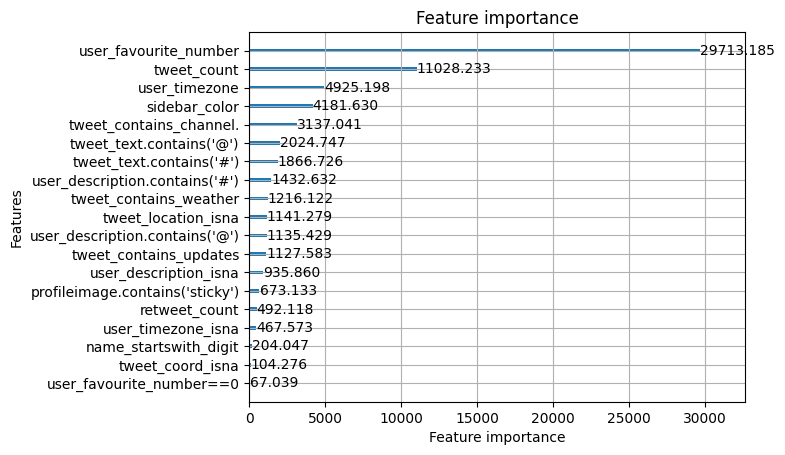

In [ ]:
def process(train): 
    cat_cols = ['tweet_coord', 'user_timezone', 'sidebar_color']
    num_cols = ['user_favourite_number', 'retweet_count', 'tweet_count']
    feature_cols = cat_cols + num_cols
    drop_cols = [c for c in list(train) if c not in feature_cols]
    train[cat_cols] = train[cat_cols].astype('category')
    
    ### New feature engineering ###
    train = train.copy() # avoids warning message
    for word in ['updates', 'weather', 'channel.']: 
        lowered = train.tweet_text.str.lower()
        train[f'tweet_contains_{word}'] = lowered.str.contains(word).astype('category')
    train["tweet_text.contains('@')"] = train.tweet_text.str.contains('@').astype('category')
    train["tweet_text.contains('#')"] = train.tweet_text.str.contains('#').astype('category')
    train["user_description.contains('@')"] = train.user_description.str.contains('@').astype('category')
    train["user_description.contains('#')"] = train.user_description.str.contains('#').astype('category')
    train["user_favourite_number==0"] = (train.user_favourite_number == 0).astype('category')
    train["profileimage.contains('sticky')"] = train.profileimage.str.contains('sticky').astype('category')
    train["name_startswith_digit"] = train.name.str[0].str.isdigit().astype('category')
    for col in ['user_description', 'tweet_coord', 'tweet_location', 'user_timezone']: 
        train[col + '_isna'] = train[col].isna().astype('category')
    return train.drop(drop_cols, axis=1)

p0 = make_pipeline(
    FunctionTransformer(process), 
    LGBMClassifier()
)

cv = cross_validate(p0, 
                    train, 
                    train['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=train['fold'])
print('CV accuracy: ', cv['test_score'].mean())

cv = cross_validate(p0, 
                    td, 
                    td['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=td['fold'])
print('Test set accuracy: ', cv['test_score'].mean())
p0.fit(td, td['gender'])
lgb.plot_importance(p0.named_steps.lgbmclassifier, importance_type='gain');

## Baseline 3 - Levenshtein distance

In [ ]:
ng.loc[ng.gender == 'M', 'probability'] = 1 - ng.loc[ng.gender == 'M', 'probability']
ng.columns = ['name', 'gender', 'probability_female']

In [ ]:
from multiprocessing import Pool, cpu_count
import time
import Levenshtein

def closest_match(username, names):
    """
    Finds the name in a list that is closest to a given username.
    """
    min_distance = float('inf')
    closest_name = None
    for name in names:
        distance = Levenshtein.distance(username, name)
        if distance < min_distance:
            min_distance = distance
            closest_name = name

    return closest_name, min_distance

def pool_func(function, input_list: list, verbose=False, n_cpu=99):
    """Uses the Pool function from the package 'multiprocessing'
    to run `function` over the list `input_list`.  The `function`
    should only take """

    n_cpu = min(n_cpu, cpu_count())
    if verbose:
        print('#############################################')
        print('Pooling function: ')
        if hasattr(function, '__name__'):
            print(function.__name__)
        print(f'{n_cpu} of {cpu_count()} cpus used')
        print('Number of function calls: ', len(input_list))

    start = time.time()
    pool = Pool(n_cpu)
    res = pool.map(function, input_list)
    pool.close()
    pool.join()

    if verbose:
        print('Time taken:',
              round((time.time() - start) / 60, 2),
              'minutes')
    return res if res else []

In [ ]:
%%time
def f(x): return closest_match(x, ng.name)
name_dis = pool_func(f, td.name)

CPU times: user 488 ms, sys: 317 ms, total: 805 ms
Wall time: 2min 23s


In [ ]:
td['closest_name'] = [x[0] for x in name_dis]
td['lev_distance'] = [x[1] for x in name_dis]
td['probability_female'] = td.closest_name.map(ng.set_index('name').probability_female.to_dict())

In [ ]:
td.to_csv(data/'twitter_data_processed.csv', index=False) 

### Pipeline

In [ ]:
tst_fold = 0
test = td[td.fold == 0]
train = td[td.fold != 0]

CV accuracy:  0.5933509996985833
Test set accuracy:  0.5947351585161803


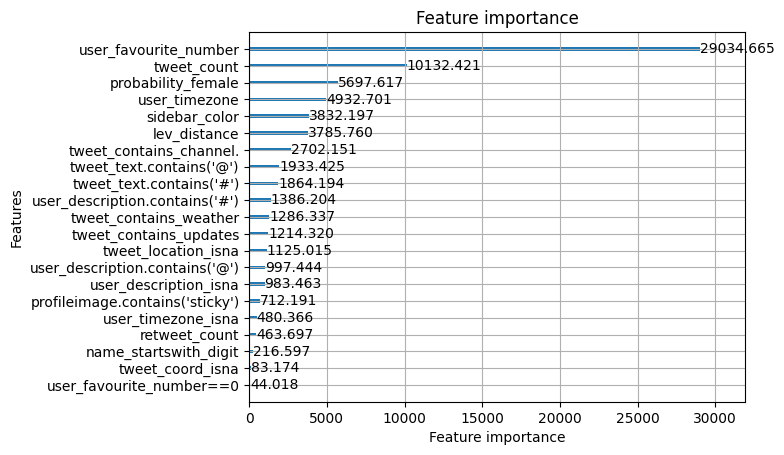

In [ ]:
def process(train): 
    cat_cols = ['tweet_coord', 'user_timezone', 'sidebar_color']
    num_cols = ['user_favourite_number', 'retweet_count', 'tweet_count', 'lev_distance', 'probability_female']
    feature_cols = cat_cols + num_cols
    drop_cols = [c for c in list(train) if c not in feature_cols]
    train[cat_cols] = train[cat_cols].astype('category')
    
    ### New feature engineering ###
    train = train.copy() # avoids warning message
    for word in ['updates', 'weather', 'channel.']: 
        lowered = train.tweet_text.str.lower()
        train[f'tweet_contains_{word}'] = lowered.str.contains(word).astype('category')
    train["tweet_text.contains('@')"] = train.tweet_text.str.contains('@').astype('category')
    train["tweet_text.contains('#')"] = train.tweet_text.str.contains('#').astype('category')
    train["user_description.contains('@')"] = train.user_description.str.contains('@').astype('category')
    train["user_description.contains('#')"] = train.user_description.str.contains('#').astype('category')
    train["user_favourite_number==0"] = (train.user_favourite_number == 0).astype('category')
    train["profileimage.contains('sticky')"] = train.profileimage.str.contains('sticky').astype('category')
    train["name_startswith_digit"] = train.name.str[0].str.isdigit().astype('category')
    for col in ['user_description', 'tweet_coord', 'tweet_location', 'user_timezone']: 
        train[col + '_isna'] = train[col].isna().astype('category')
    return train.drop(drop_cols, axis=1)

p0 = make_pipeline(
    FunctionTransformer(process), 
    LGBMClassifier()
)

cv = cross_validate(p0, 
                    train, 
                    train['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=train['fold'])
print('CV accuracy: ', cv['test_score'].mean())

cv = cross_validate(p0, 
                    td, 
                    td['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=td['fold'])
print('Test set accuracy: ', cv['test_score'].mean())
p0.fit(td, td['gender'])
lgb.plot_importance(p0.named_steps.lgbmclassifier, importance_type='gain');

In [ ]:
2 ** 8

256

In [ ]:
%%time
grid_params = {
        'lgbmclassifier__num_leaves': [2 ** x - 1 for x in range(4, 8)],
        'lgbmclassifier__colsample_bytree': [.3, .5, .7, .9], 
        'lgbmclassifier__n_estimators': [2 ** x - 1 for x in range(4, 8)], 
        'lgbmclassifier__subsample_freq': [1],
        'lgbmclassifier__subsample': [.3, .5, .7, .9], 
}
display(grid_params)
grid_cv = GridSearchCV(p0, param_grid=grid_params, n_jobs=-1)
grid_cv.fit(train, train['gender'])

{'lgbmclassifier__num_leaves': [15, 31, 63, 127],
 'lgbmclassifier__colsample_bytree': [0.3, 0.5, 0.7, 0.9],
 'lgbmclassifier__n_estimators': [15, 31, 63, 127],
 'lgbmclassifier__subsample_freq': [1],
 'lgbmclassifier__subsample': [0.3, 0.5, 0.7, 0.9]}

/tmp/ipykernel_7711/3566647503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_cols] = train[cat_cols].astype('category')


CPU times: user 1min 24s, sys: 12.3 s, total: 1min 36s
Wall time: 1min 56s


GridSearchCV(estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function process>)),
                                       ('lgbmclassifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__colsample_bytree': [0.3, 0.5, 0.7,
                                                              0.9],
                         'lgbmclassifier__n_estimators': [15, 31, 63, 127],
                         'lgbmclassifier__num_leaves': [15, 31, 63, 127],
                         'lgbmclassifier__subsample': [0.3, 0.5, 0.7, 0.9],
                         'lgbmclassifier__subsample_freq': [1]})

In [ ]:
display(grid_cv.best_params_)
display(grid_cv.best_score_)

{'lgbmclassifier__colsample_bytree': 0.9,
 'lgbmclassifier__n_estimators': 63,
 'lgbmclassifier__num_leaves': 31,
 'lgbmclassifier__subsample': 0.7,
 'lgbmclassifier__subsample_freq': 1}

0.5958508626910113

CV accuracy:  0.5958508626910113
Test set accuracy:  0.5958703228776221


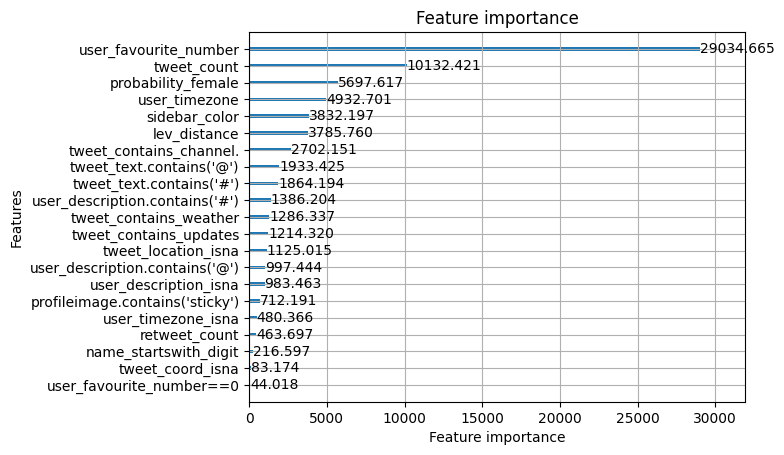

In [ ]:
cv = cross_validate(grid_cv.best_estimator_, 
                    train, 
                    train['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=train['fold'])
print('CV accuracy: ', cv['test_score'].mean())

cv = cross_validate(grid_cv.best_estimator_, 
                    td, 
                    td['gender'], 
                    scoring=lambda e, x, y: accuracy(y, e.predict(x)),
                    groups=td['fold'])
print('Test set accuracy: ', cv['test_score'].mean())
p0.fit(td, td['gender'])
lgb.plot_importance(p0.named_steps.lgbmclassifier, importance_type='gain');

# Scratch work - some orignal eda that is less clear but is kept here for reference

#### Initial investigation - can be ignored
This code is left here for historical preservation, but I opted for the simpler solution to remove duplicates in the next subsection.

In [ ]:
td = pd.read_csv(data/'twitter_data.csv')
td['date'] = pd.to_datetime(td.created)

date_vc = td.date.value_counts()
date_vc[date_vc > 1]

2015-08-24 14:19:00    30
2012-03-17 13:07:00    27
2010-07-06 13:21:00    24
2010-04-13 02:10:00    18
2013-12-18 14:24:00    15
                       ..
2012-02-26 08:49:00     2
2013-08-28 00:39:00     2
2012-07-03 09:46:00     2
2010-05-14 09:44:00     2
2014-03-09 17:53:00     2
Name: date, Length: 872, dtype: int64

In [ ]:
td.name.value_counts()

TudoSobreQuase    30
94heskind         27
Map_Game          24
naijama           18
aSEATaxiCab       15
                  ..
06042jcsa          1
rumucijaseho       1
02532gnlc          1
stwc29530          1
Gbuschrist         1
Name: name, Length: 18793, dtype: int64

In [ ]:
td[td.name == 'TudoSobreQuase'].head()

,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
7889,815727207,brand,8/24/15 14:19,NaN,25,3B94D9,TudoSobreQuase,https://pbs.twimg.com/profile_images/635925197...,0,0,https://t.co/miYAuiSOD0 like and subscribe to ...,NaN,151386,NaN,NaN,2015-08-24 14:19:00
7983,815727301,brand,8/24/15 14:19,NaN,25,3B94D9,TudoSobreQuase,https://pbs.twimg.com/profile_images/635925197...,0,0,https://t.co/miYAuiSOD0 like and subscribe to ...,NaN,151386,NaN,NaN,2015-08-24 14:19:00
8062,815727380,brand,8/24/15 14:19,NaN,25,3B94D9,TudoSobreQuase,https://pbs.twimg.com/profile_images/635925197...,0,0,https://t.co/miYAuiSOD0 like and subscribe to ...,NaN,151386,NaN,NaN,2015-08-24 14:19:00
8141,815727459,brand,8/24/15 14:19,NaN,25,3B94D9,TudoSobreQuase,https://pbs.twimg.com/profile_images/635925197...,0,0,https://t.co/miYAuiSOD0 like and subscribe to ...,NaN,151386,NaN,NaN,2015-08-24 14:19:00
8202,815727520,brand,8/24/15 14:19,NaN,25,3B94D9,TudoSobreQuase,https://pbs.twimg.com/profile_images/635925197...,0,0,https://t.co/miYAuiSOD0 like and subscribe to ...,NaN,151386,NaN,NaN,2015-08-24 14:19:00


In [ ]:
print("dropping extra rows with duplicated 'gender', 'created', 'user_description', 'user_favourite_number', 'link_color', 'name'")
td.drop_duplicates(['gender', 'created', 'user_description', 'user_favourite_number', 'link_color', 'name'], inplace=True)

dropping rows with duplicated 'gender', 'created', 'user_description', 'user_favourite_number', 'link_color', 'name'


In [ ]:
names_still_duplicated = set(td.name.value_counts()[td.name.value_counts() > 1].index)

In [ ]:
print('looking at all the rows with duplicated names')
td[td.name.isin(names_still_duplicated)].sort_values('name')

looking at all the rows with duplicated names


,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
892,815720117,brand,10/25/15 13:00,NaN,0,0084B4,101918171615aa,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,@onedirection \r\nArtist of the Year \r\n#AMAs...,NaN,75,NaN,NaN,2015-10-25 13:00:00
4212,815723507,unknown,10/25/15 13:00,NaN,0,0084B4,101918171615aa,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,@onedirection \r\nArtist of the Year \r\n#AMAs...,NaN,75,NaN,NaN,2015-10-25 13:00:00
11537,815730923,brand,9/13/15 10:23,NaN,2,0084B4,10videos_2nd,https://pbs.twimg.com/profile_images/643113457...,0,C0DEED,Amateur Daughter Seduced And Fucked By Old Fat...,NaN,4127,NaN,NaN,2015-09-13 10:23:00
11475,815730857,unknown,9/13/15 10:23,NaN,2,0084B4,10videos_2nd,https://pbs.twimg.com/profile_images/643113457...,0,C0DEED,Graceful Blonde Apprentice Expand Her Extra Lo...,NaN,4127,NaN,NaN,2015-09-13 10:23:00
13832,815733281,brand,11/14/12 5:18,NaN,590,0084B4,1D__Sheila,https://pbs.twimg.com/profile_images/546728358...,0,C0DEED,I Just Voted for @onedirection for #ArtistOfTh...,NaN,951,NaN,Arizona,2012-11-14 05:18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15107,815734583,male,8/27/15 14:54,NaN,0,0084B4,xlarspanda,https://pbs.twimg.com/profile_images/637980218...,0,C0DEED,I wanna win! \r\n\r\nWe win you lose!\r\n...,NaN,57604,NaN,NaN,2015-08-27 14:54:00
14993,815734464,unknown,8/27/15 14:54,NaN,0,0084B4,xlarspanda,https://pbs.twimg.com/profile_images/637980218...,0,C0DEED,I wanna win! Hull Uni Students! Follow us and ...,NaN,57604,NaN,NaN,2015-08-27 14:54:00
15210,815734688,brand,8/27/15 14:54,NaN,0,0084B4,xlarspanda,https://pbs.twimg.com/profile_images/637980218...,0,C0DEED,"I wanna win! Rainbow hair, don't care? Show us...",NaN,57604,NaN,NaN,2015-08-27 14:54:00
10664,815730027,brand,9/23/07 7:49,Ready...Set...XO! Official Twitter for the sit...,3352,FF0000,xonecole,https://pbs.twimg.com/profile_images/630627338...,0,FFFFFF,#MCM Anyone? #xoMan &amp; Former NFL Player @D...,NaN,125510,LA‰Ïö•ü‰Ïö•üNY‰Ïö•ü‰Ïö•üAZ,Quito,2007-09-23 07:49:00


In [ ]:
print('Many rows seem to be duplicated with just the `gender` switched to "unknown". Lets drop rows with unknown gender')
old = len(td)
td = td[td.gender != 'unknown']
new = len(td)
rows_dropped = old - new
print(f'We have dropped {rows_dropped} rows with "unknown" `gender`')

Many rows seem to be duplicated with just the `gender` switched to "unknown". Lets drop rows with unknown gender
We have dropped -1093 rows with "unknown" `gender`


In [ ]:
print('looking at all the rows with duplicated names')
td[td.name.isin(set(td.name.value_counts()[td.name.value_counts() > 1].index))].sort_values('name')

looking at all the rows with duplicated names


,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
12887,815732312,female,11/14/12 5:18,NaN,590,0084B4,1D__Sheila,https://pbs.twimg.com/profile_images/546728358...,0,C0DEED,I Just Voted for @onedirection for #ArtistOfTh...,NaN,951,NaN,Arizona,2012-11-14 05:18:00
13832,815733281,brand,11/14/12 5:18,NaN,590,0084B4,1D__Sheila,https://pbs.twimg.com/profile_images/546728358...,0,C0DEED,I Just Voted for @onedirection for #ArtistOfTh...,NaN,951,NaN,Arizona,2012-11-14 05:18:00
8590,815727915,male,10/02/2014 19:11,1d ddl lm 5h mgc,403,ABB8C2,94hesflawless,https://pbs.twimg.com/profile_images/658728664...,0,0,‰÷_ @Harry_Styles\r\nOne day I‰Ûªm gonna meet ...,NaN,47413,NaN,London,2014-10-02 19:11:00
7642,815726958,female,10/02/2014 19:11,1d ddl lm 5h mgc,403,ABB8C2,94hesflawless,https://pbs.twimg.com/profile_images/658728664...,0,0,‰÷_ @Harry_Styles\r\nOne day I‰Ûªm gonna meet ...,NaN,47413,NaN,London,2014-10-02 19:11:00
10199,815729555,male,3/17/12 13:07,secret little rendezvous,54635,405,94heskind,https://pbs.twimg.com/profile_images/658393897...,0,FFFFFF,@Harry_Styles thank you for being so genuine a...,NaN,177809,‰ãarry and laura ˆÂ»ˆÂÒ,Dublin,2012-03-17 13:07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922,815726233,female,06/12/2014 02:56,‰ÑÜ •_À•_À•_À•_À•_À\r\n‹ÛÛ‹ÛÛ‹ÛÛ ‰ö´‹ÛÛJEKET...,5,0084B4,wotanonymous,https://pbs.twimg.com/profile_images/617094599...,0,C0DEED,VIDEO: James Bond Spectre world premiere: Afte...,NaN,465759,NaN,NaN,2014-06-12 02:56:00
15210,815734688,brand,8/27/15 14:54,NaN,0,0084B4,xlarspanda,https://pbs.twimg.com/profile_images/637980218...,0,C0DEED,"I wanna win! Rainbow hair, don't care? Show us...",NaN,57604,NaN,NaN,2015-08-27 14:54:00
15107,815734583,male,8/27/15 14:54,NaN,0,0084B4,xlarspanda,https://pbs.twimg.com/profile_images/637980218...,0,C0DEED,I wanna win! \r\n\r\nWe win you lose!\r\n...,NaN,57604,NaN,NaN,2015-08-27 14:54:00
2527,815721815,brand,9/23/07 7:49,Ready...Set...XO! Official Twitter for the sit...,3351,FF0000,xonecole,https://pbs.twimg.com/profile_images/630627338...,2,FFFFFF,This @NYTimes Editor Dressed Up As Empire's Co...,NaN,125504,LA‰Ïö•ü‰Ïö•üNY‰Ïö•ü‰Ïö•üAZ,Quito,2007-09-23 07:49:00


In [ ]:
print('removing rows where all columns are duplicated except `gender`')
old = len(td)
td.drop_duplicates(['created', 'user_description',
       'user_favourite_number', 'link_color', 'name', 'profileimage',
       'retweet_count', 'sidebar_color', 'tweet_coord',
       'tweet_count', 'tweet_location', 'user_timezone'], keep=False, inplace=True)
new = len(td)
rows_dropped = old - new
print(f'We have dropped {rows_dropped} rows which were duplicate rows \n\
    with different `gender`, which would lead to confusion since we don\'t \n\
    know what label they are')


removing rows where all columns are duplicated except `gender`
We have dropped 128 rows which were duplicate rows 
    with different `gender`, which would lead to confusion since we don't 
    know what label they are


/tmp/ipykernel_7711/46154858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td.drop_duplicates(['created', 'user_description',


In [ ]:
print('looking at all the rows with duplicated names')
td[td.name.isin(set(td.name.value_counts()[td.name.value_counts() > 1].index))].sort_values('name')

looking at all the rows with duplicated names


,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
7352,815726666,female,5/18/13 18:06,Principal of Pocomoke High School. Views & opi...,2831,0084B4,Aewallace8,https://pbs.twimg.com/profile_images/430824459...,0,C0DEED,KI with a block out and the Warriors take it a...,NaN,5537,NaN,NaN,2013-05-18 18:06:00
17332,815736858,female,5/18/13 18:06,Principal of Pocomoke High School. Views & opi...,2856,0084B4,Aewallace8,https://pbs.twimg.com/profile_images/430824459...,0,C0DEED,And #Poco takes possession again!!!!,NaN,5572,NaN,NaN,2013-05-18 18:06:00
16137,815735638,male,06/06/2012 05:29,If you cant have a laugh have a bag of chips a...,27772,0084B4,AndybBenson,https://pbs.twimg.com/profile_images/656945167...,0,C0DEED,@Paula_Jayne_ LOL.....I don't do it for me _Ù÷...,NaN,69717,"BURMINGUM UK (DUDLEY,REALLY",London,2012-06-06 05:29:00
12529,815731943,male,06/06/2012 05:29,If you cant have a laugh have a bag of chips a...,27771,0084B4,AndybBenson,https://pbs.twimg.com/profile_images/656945167...,0,C0DEED,@WifeofMrH and you're getting as bad as me typ...,NaN,69717,"BURMINGUM UK (DUDLEY,REALLY",London,2012-06-06 05:29:00
12889,815732314,brand,2/18/15 9:56,#Authors #Publicists #LiteraryAgents #Marketin...,0,9266CC,BookTalkRadio,https://pbs.twimg.com/profile_images/568107633...,0,0,How the #SAV Act will Draw Attention to #Milit...,NaN,113357,"Los Angeles, California",NaN,2015-02-18 09:56:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9103,815728440,male,3/27/09 8:50,"I run, I read, and I talk about it all.",94,D02B55,thetk42one,https://pbs.twimg.com/profile_images/656172802...,0,FFFFFF,Good gravy. My Negative Nancy meter is going t...,NaN,18054,"King George, VA",Eastern Time (US & Canada),2009-03-27 08:50:00
17170,815736692,female,03/02/2011 09:17,An administrator for a facilities management c...,3678,013F4C,wendycockcroft,https://pbs.twimg.com/profile_images/648243670...,0,FFFFFF,I'm a #migrant. I moved to the #UK in search o...,NaN,28031,"Manchester, UK",London,2011-03-02 09:17:00
3318,815722610,female,03/02/2011 09:17,An administrator for a facilities management c...,3665,013F4C,wendycockcroft,https://pbs.twimg.com/profile_images/648243670...,0,FFFFFF,"From the ""Unfortunate ad placing"" dept. https:...",NaN,27998,"Manchester, UK",London,2011-03-02 09:17:00
10664,815730027,brand,9/23/07 7:49,Ready...Set...XO! Official Twitter for the sit...,3352,FF0000,xonecole,https://pbs.twimg.com/profile_images/630627338...,0,FFFFFF,#MCM Anyone? #xoMan &amp; Former NFL Player @D...,NaN,125510,LA‰Ïö•ü‰Ïö•üNY‰Ïö•ü‰Ïö•üAZ,Quito,2007-09-23 07:49:00


In [ ]:
print('It looks like we have a lot of duplicates with just a \n\
different favourite color. Lets try dropping duplicates \n\
that have the same gender, name, created, and description.')
td.drop_duplicates(['gender', 'created', 'user_description', 'name'], inplace=True)

It looks like we have a lot of duplicates with just a 
different favourite color. Lets try dropping duplicates 
that have the same gender, name, created, and description.


/tmp/ipykernel_7711/388737004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td.drop_duplicates(['gender', 'created', 'user_description', 'name'], inplace=True)


In [ ]:
print('looking at all the rows with duplicated names')
td[td.name.isin(set(td.name.value_counts()[td.name.value_counts() > 1].index))].sort_values('name')

looking at all the rows with duplicated names


,unit_id,gender,created,user_description,user_favourite_number,link_color,name,profileimage,retweet_count,sidebar_color,tweet_text,tweet_coord,tweet_count,tweet_location,user_timezone,date
5708,815725013,female,2/18/15 9:56,#Authors #Publicists #LiteraryAgents #Marketin...,0,9266CC,BookTalkRadio,https://pbs.twimg.com/profile_images/568107633...,0,0,Unanswered prayers can be the best #gifts a pe...,NaN,113327,"Los Angeles, California",NaN,2015-02-18 09:56:00
12889,815732314,brand,2/18/15 9:56,#Authors #Publicists #LiteraryAgents #Marketin...,0,9266CC,BookTalkRadio,https://pbs.twimg.com/profile_images/568107633...,0,0,How the #SAV Act will Draw Attention to #Milit...,NaN,113357,"Los Angeles, California",NaN,2015-02-18 09:56:00
13831,815733280,brand,6/21/14 10:11,Is it Hi or Hey? || Turn our Notifs on! || Kin...,13572,DD2E44,Dem5SOS_Updates,https://pbs.twimg.com/profile_images/644599167...,0,0,Ashton and Luke with @sleepyshel ~~Jul https:/...,NaN,33557,N. America | EU | AUS | NZ,Pacific Time (US & Canada),2014-06-21 10:11:00
1219,815720451,brand,6/21/14 10:11,Is it Hi or Hey? || Turn our Notifs on! || Kin...,13542,DD2E44,Dem5SOS_Updates,https://pbs.twimg.com/profile_images/644599167...,0,0,"@5sosupdateplace i feel ya, it seemed more int...",NaN,33512,N. America | EU | AUS | NZ,Pacific Time (US & Canada),2014-06-21 10:11:00
11200,815730574,female,11/06/2014 17:08,Fuzzy Chimera Dragon Thing.,6293,0084B4,Dessy_Dragon,https://pbs.twimg.com/profile_images/613193891...,0,C0DEED,@voidflame @BarabiRedtata Your icon and curren...,NaN,7045,Northern Virginia,Eastern Time (US & Canada),2014-11-06 17:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,815722347,female,9/24/15 8:41,NaN,0,0084B4,prslava15,https://pbs.twimg.com/profile_images/647073788...,0,C0DEED,EVERYDAYDAYILOVEYOU Forevermore\r\nRide the ed...,NaN,12749,NaN,NaN,2015-09-24 08:41:00
17991,815737532,female,8/13/13 5:14,"od,5sos&cam are my everything.‰Ï¬",12965,ABB8C2,pxmpl,https://pbs.twimg.com/profile_images/658693689...,0,FFFFFF,I Just Voted for @onedirection for #ArtistOfTh...,NaN,41800,luke,Paris,2013-08-13 05:14:00
16279,815735783,brand,8/13/13 5:14,"od,5sos&cam are my everything.‰Ï¬",12965,ABB8C2,pxmpl,https://pbs.twimg.com/profile_images/658693689...,0,FFFFFF,I Just Voted for @5SOS for #ArtistOfTheYear Go...,NaN,41799,luke,Paris,2013-08-13 05:14:00
1116,815720347,brand,3/28/15 2:29,NaN,140,0099B9,rtc855,https://pbs.twimg.com/profile_images/653964625...,0,5ED4DC,EVERYDAYDAYILOVEYOU Forevermore\r\nWeep with t...,NaN,12169,NaN,Volgograd,2015-03-28 02:29:00


In [ ]:
td.drop_duplicates(['gender', 'created', 'name'], inplace=True)
print('looking at all the rows with duplicated names')
td[td.name.isin(set(td.name.value_counts()[td.name.value_counts() > 1].index))].groupby('name')['gender'].nunique()

looking at all the rows with duplicated names


/tmp/ipykernel_7711/4100603158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td.drop_duplicates(['gender', 'created', 'name'], inplace=True)


name
BookTalkRadio      2
Dessy_Dragon       2
GermanWizard11     2
HoustonHavens      2
JohnnyPetrini      2
KimberlyRules      2
KinkyKian13        2
LebretonAbby       2
LukeIsASequin      2
OrionsBlack        2
Quen2Liz           2
Shaggy_Saalc       2
SpartanGrp         2
TalkLFC07          2
_Desperlady_       2
_WEYNT             2
allah_the_pagan    2
allthelowex        2
bearaboi           2
doingerins         2
easy_e93           2
irisannwests       2
isimplytessa       2
johnIaurens        2
kyungsmoI          2
mackymarz          2
maiagillian        2
ohiscot21          2
poor2016           1
prslava15          2
pxmpl              2
rtc855             2
Name: gender, dtype: int64

#### A simpler process for duplicate removal  (1:45)
After removing rows with "unknown" `gender`, we will drop rows duplicated with respect to `created`, `name`, and `gender`, keeping the first row. Then we will drop the rows duplicated with respect to `created`, `name`, but with different `genders`, and we will not keep the first row since we can't be sure how to correctly classify these rows. 

,name,gender,probability
0,Aaban,M,1.0
1,Aabha,F,1.0
2,Aabid,M,1.0
3,Aabriella,F,1.0
4,Aada,F,1.0


array(['M', 'F'], dtype=object)

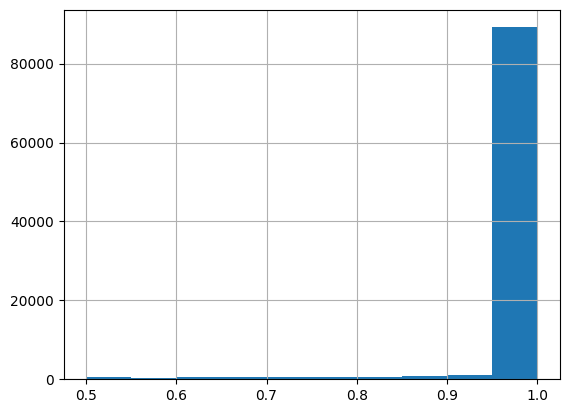

array(['M', 'F'], dtype=object)

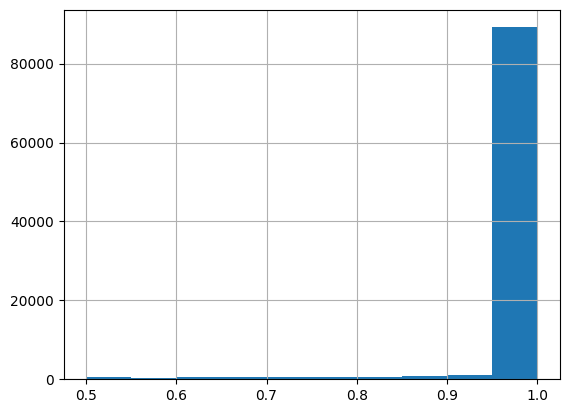

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()